# L10 Basic CNN

In [1]:
import torch
import numpy as np

BATCH_SIZE = 64

In [2]:
# data
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader

transform = transforms.Compose([ transforms.ToTensor(), transforms.Normalize((0.1307, ), (0.3081, )) ])
train_dataset = datasets.MNIST(root='dataset/mnist', train=True, transform=transform, download=True) 
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = datasets.MNIST(root='dataset/mnist', train=False, transform=transform, download=True) 
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(train_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: dataset/mnist
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )


In [3]:
# model
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = torch.nn.ModuleList()
        self.fc = torch.nn.ModuleList()
        
        self.conv.append(torch.nn.Conv2d(1, 10, kernel_size=5, stride=1, bias=False)) # in_channel, out_channel; padding=1
        self.conv.append(torch.nn.Conv2d(10, 20, kernel_size=5, stride=1, bias=False))
        self.pooling = torch.nn.MaxPool2d(2) # filter 2x2, therefore stride=2
        self.fc.append(torch.nn.Linear(320, 160)) # in_dim, out_dim;
        self.fc.append(torch.nn.Linear(160, 10))
    
    def forward(self, x):
        batch_size = x.size(0) # get N from (N,1,28,28)
        fc_size = len(self.fc)
        
        for layer in self.conv:
            x = torch.relu(self.pooling(layer(x))) # first relu then pooling is also ok
        x = x.view(batch_size, -1) # flatten
        for layer_index in range(fc_size-1): # last layer donot need RELU activate
            x = torch.relu(self.fc[layer_index](x))
        return self.fc[fc_size-1](x)
    
net = Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device) # move to GPU

Net(
  (conv): ModuleList(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (1): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1), bias=False)
  )
  (fc): ModuleList(
    (0): Linear(in_features=320, out_features=160, bias=True)
    (1): Linear(in_features=160, out_features=10, bias=True)
  )
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [4]:
# criterion
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.5)

In [5]:
# train
def train(epoch):
    running_loss = 0
    for batch_i, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device) # move to GPU
        y_hat = net(x)
        loss = criterion(y_hat, y.long()) # torch.Tensor() is float, torch.LongTensor() is num; in this case, .long() removed is ok
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        running_loss += loss.item()
        
    if(running_loss <= 1e-5 or epoch >= 10):
        return True, epoch, running_loss / BATCH_SIZE
    else:
        epoch += 1
        return False, epoch, running_loss / BATCH_SIZE

In [6]:
# test
def test():
    correct = 0
    total = 0
    with torch.no_grad():
        for (x, y) in test_loader:
            x, y = x.to(device), y.to(device) # move to GPU
            y_hat = net(x)
            value, pred_index = torch.max(y_hat.data, dim=1)
            total += y.size(0)
            correct += (pred_index == y).sum().item()
    return correct / total

In [9]:
%%time
# epoch
epoch = 0
loss = []
accurate_rate = []

while True:
    train_over, epoch, epoch_loss = train(epoch) 
    loss.append(epoch_loss)
    acc = test()
    accurate_rate.append(acc)
    
    if(train_over):
        break

CPU times: total: 23min 6s
Wall time: 3min 51s


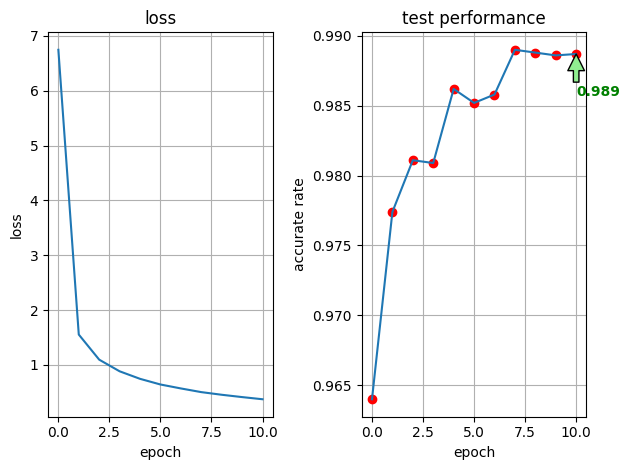

In [8]:
# plot
import matplotlib.pyplot as plt

plt.subplot(121)
plt.title("loss")
plt.plot(loss)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid(True)

plt.subplot(122)
plt.title("test performance")
plt.plot(accurate_rate, "ro")
plt.plot(accurate_rate)
plt.xlabel("epoch")
plt.ylabel("accurate rate")
plt.grid(True)
px, py = 10, accurate_rate[-1]
# plt.text(px-0.2, py-0.002, "%0.3f"%(accurate_rate[-1]), rotation=-30, color='gray')
plt.annotate("%0.3f"%(accurate_rate[-1]), xy=(px, py), xytext=(px,py-0.003),
                           color="green", weight="heavy", fontsize=10,
                           arrowprops={"facecolor": "lightgreen"})

plt.tight_layout()
plt.savefig("image/L10_performance.png")
plt.show()